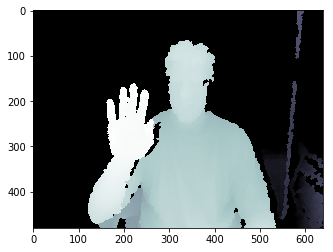

In [4]:
import matplotlib.pyplot as mpplot
from skimage import io as skimio

img_name = '/home/xwu/data/nyu_hand/test/depth_1_0000001.png'
mat_name = '/home/xwu/data/nyu_hand/test/joint_data.mat'

img = skimio.imread(img_name).astype(float)
dep = (img[:, :, 1] * 256) + img[:, :, 2]
mpplot.imshow(dep, cmap=mpplot.cm.bone_r)
mpplot.show()

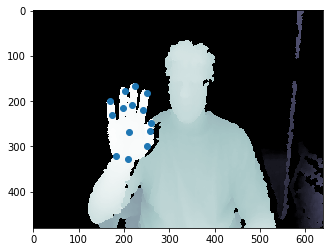

2.9665159217984183e-13


In [14]:
import numpy as np
import scipy.io
from collections import namedtuple

caminfo = namedtuple('caminfo', ['focal', 'centre'])
ci = caminfo((588.036865, 587.075073), (320, 240))

def d2z_to_raw(p2z, caminfo):
    """ reproject 2d poses to 3d.
        p2z: nx3 array, 2d position and real z
    """
    p2z = p2z.astype(float)
    pose2d = p2z[:, 0:2]
    pose_z = np.array(p2z[:, 2]).reshape(-1, 1)
    # pose2d = pose2d[:, ::-1]  # image coordinates: reverse x, y
    pose3d = (pose2d - caminfo.centre) / caminfo.focal * pose_z
    return np.hstack((pose3d, pose_z))

def raw_to_2dz(points3, caminfo):
    """ project 3D point onto image plane using camera info
        Args:
            points3: nx3 array, raw input in real world coordinates
    """
    points3 = points3.astype(float)
    pose_z = points3[:, 2]
    pose2d = points3[:, 0:2] / pose_z.reshape(-1, 1) * caminfo.focal + caminfo.centre
    #pose2d = pose2d[:, ::-1]  # image coordinates: reverse x, y
    return pose2d, pose_z

def raw_to_2d(points3, caminfo):
    pose2d, _ = raw_to_2dz(points3, caminfo)
    return pose2d

mat_reader = scipy.io.loadmat(mat_name)
join_keep = (0, 3, 6, 9, 12, 15, 18, 21, 24, 25, 27, 30, 31, 32)
poses = mat_reader['joint_xyz'][0, 0, join_keep, :]
#print(poses)
poses[:, 1] *= -1
pose2d, pose_z = raw_to_2dz(poses, ci)
#print(pose2d)
mpplot.imshow(dep, cmap=mpplot.cm.bone_r)
mpplot.plot(pose2d[:, 0], pose2d[:, 1], 'o')
mpplot.show()
uvd = np.hstack((
    pose2d,
    pose_z.reshape(-1, 1))
)
poses_rep = d2z_to_raw(uvd, ci)
print(np.sum(np.abs(poses - poses_rep)))